In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# Electricity Consumption Outlier Detection for the entire 2024

Goal: implement a combination of two unsupervised models to detect anomaly energy consumption. 
point of the analysis should not simply detect the global anomaly energy but identify 'irregularities' in the shape of the time series.

Step 1: Transforming the data

Step 2: Train a Deep Learning autoencoder to encode the series and visualize [use local Outlier Factor to the reduced data to detect anomalies]

### Step 1

dataset shape: (X: 1382)

X is 6 hours by 6 hours of data for the whole year of 2024

Reshaping the data

new shape: (1482995, 96) 'each row is a day, each column is a 15 min' ( 4063*365=1482995)

Apart from consumption add: holidays, weekends, seasons, outside temperature, number of appliances, house surface, income, and family components.
(using to make sense of the anomalous households)

Build basic statistics: mean day consumption in the regions (identify regions with highest consumption with standard deviation), and build histograms for the characteristics of the households.

### Step 2


In [2]:
all_data = pd.DataFrame()
total = 0

for root, folder, files in os.walk('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/consumption_data/smart_meter/6hour_interval'):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path, low_memory=False)
            all_data = pd.concat([all_data, data], ignore_index=True)
            rows, cols = data.shape
            total = total + rows

all_data = all_data[['household_ID', 'DATE', 'TIME', 'TOTAL_IMPORT (kWh)']].copy()
all_data['TIME'] = all_data['TIME'].str.extract(r'(\d{2}:\d{2}:\d{2})')
all_data['DATETIME'] = pd.to_datetime(all_data['DATE'] + ' ' + all_data['TIME'], errors='coerce')
all_data['TOTAL_IMPORT (kWh)'] = pd.to_numeric(all_data['TOTAL_IMPORT (kWh)'], errors='coerce')
all_data = all_data.sort_values(['household_ID', 'DATETIME'])

all_data['TOTAL_IMPORT (kWh)'] = (
    all_data.groupby('household_ID')['TOTAL_IMPORT (kWh)'].diff()
)

# filter 2023/06/23 to 2023/10/22

start_date = '2023-06-23'
end_date = '2023-10-22'
all_data = all_data[(all_data['DATETIME'] >= start_date) & (all_data['DATETIME'] <= end_date)]
all_data['DATETIME'] = all_data['DATETIME'].dt.floor('6h')
all_data = all_data.drop_duplicates(subset=['household_ID', 'DATETIME'], keep='first')
all_data = all_data.pivot(index='DATETIME', columns='household_ID', values='TOTAL_IMPORT (kWh)')

all_data = all_data.bfill()
all_data.dropna(axis=1, inplace=True)

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(all_data.values)

#Creating Sequences: Autoencoders for time-series data often work with fixed-length sequences.
# Going with 30 data points for 10 days

sequence_length = 30
sequences = []
for i in range(len(normalized_data) - sequence_length + 1):
    sequences.append(normalized_data[i:i + sequence_length])
sequences = np.array(sequences)

In [3]:
sequence_input = Input(shape=(sequence_length, normalized_data.shape[1]))
# Encoder
encoded = LSTM(128, activation='relu', return_sequences=False)(sequence_input)
# Decoder
decoded = RepeatVector(sequence_length)(encoded)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(normalized_data.shape[1]))(decoded)

# Model
autoencoder = Model(sequence_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 2804)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     1,501,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 2804)       │       361,716 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,994,996 (7.61 MB)

 Trainable params: 1,994,996 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Training the autoencoder to minimize the data reconstruction error

X_train, X_val = train_test_split(sequences, test_size=0.2, random_state=42)

history = autoencoder.fit(
    X_train, X_train,
    epochs=50, #adjust
    batch_size=32,
    validation_data=(X_val, X_val),
    verbose=1
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 3.0633 - val_loss: 5.8695
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 20.9253 - val_loss: 411.5662
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 299.5842 - val_loss: 227.0307
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 183.3656 - val_loss: 23.8211
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 107.1607 - val_loss: 145.4508
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 1011.5639 - val_loss: 339.1584
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 618.9313 - val_loss: 845.3994
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 826.4483 - val_loss: 559.4903
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 882.3938 - val_loss: 1563.1199
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 942.5138 - val_loss: 201.9055
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 260.3483 - val_loss: 71.9671
Epoch 12/50
12/12

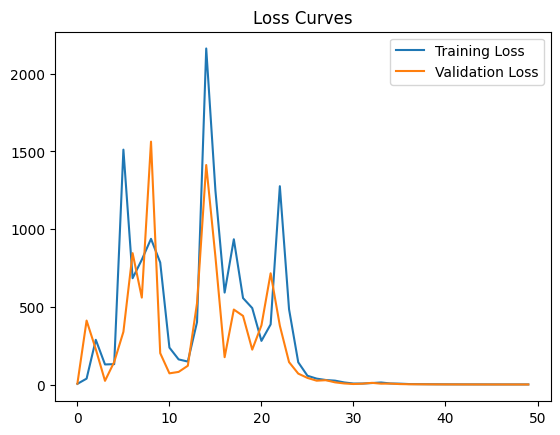

In [5]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [26]:
# Calculating the data reconstruction errors
reconstructed = autoencoder.predict(sequences)
reconstruction_errors = np.mean(np.square(sequences - reconstructed), axis=(1, 2))

#implementing a threshold for anomalies - 95the percentile
threshold = np.percentile(reconstruction_errors, 98)

anomalies = reconstruction_errors > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Number of anomalies detected: 9


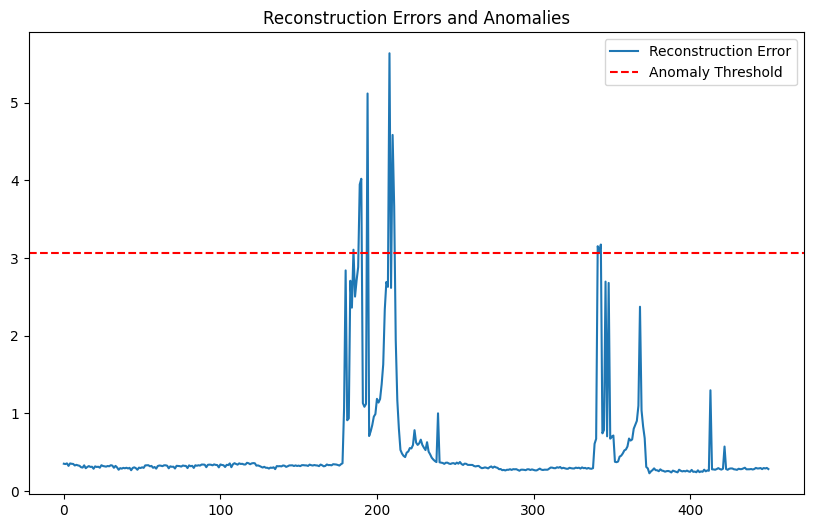

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.legend()
plt.title('Reconstruction Errors and Anomalies')
plt.show()

In [40]:
anomalous_sequences = sequences[anomalies]
anomalous_reconstructions = reconstructed[anomalies]
per_household_errors = np.square(anomalous_sequences - anomalous_reconstructions)

household_errors = np.mean(per_household_errors, axis=(0, 1))

household_threshold = np.percentile(household_errors, 90)
anomalous_household_indices = np.where(household_errors > household_threshold)[0]
household_names = all_data.columns[anomalous_household_indices]

print(f"Number of anomalous households: {len(anomalous_household_indices)}")
print("Anomalous households:", list(household_names))


Number of anomalous households: 281
Anomalous households: ['ID0013', 'ID0276', 'ID0296', 'ID0584', 'ID0619', 'ID0624', 'ID0634', 'ID0657', 'ID0658', 'ID0698', 'ID0842', 'ID0930', 'ID0999', 'ID1007', 'ID1008', 'ID1028', 'ID1069', 'ID1102', 'ID1104', 'ID1113', 'ID1144', 'ID1264', 'ID1276', 'ID1308', 'ID1320', 'ID1342', 'ID1378', 'ID1407', 'ID1437', 'ID1480', 'ID1486', 'ID1497', 'ID1504', 'ID1523', 'ID1527', 'ID1538', 'ID1564', 'ID1567', 'ID1575', 'ID1581', 'ID1593', 'ID1622', 'ID1624', 'ID1673', 'ID1737', 'ID1826', 'ID1892', 'ID2068', 'ID2083', 'ID2105', 'ID2176', 'ID2179', 'ID2187', 'ID2224', 'ID2227', 'ID2253', 'ID2282', 'ID2300', 'ID2323', 'ID2340', 'ID2358', 'ID2384', 'ID2418', 'ID2462', 'ID2472', 'ID2479', 'ID2489', 'ID2508', 'ID2513', 'ID2539', 'ID2556', 'ID2580', 'ID2581', 'ID2584', 'ID2590', 'ID2620', 'ID2632', 'ID2636', 'ID2658', 'ID2684', 'ID2695', 'ID2708', 'ID2727', 'ID2747', 'ID2751', 'ID2793', 'ID2797', 'ID2798', 'ID2802', 'ID2805', 'ID2874', 'ID2894', 'ID2902', 'ID2939', '

In [41]:
pd.DataFrame(household_names).to_csv("anomalous_households_autoencoder.csv", index=False)